In [1]:
# =============
#   PAQUETES
# =============
import numpy as np        
import sympy as sp
from scipy.signal import ZerosPolesGain, TransferFunction, bode
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ==========================
#   CARACTERÍSTICAS LM324
# ==========================
Ad0_dB    = 100       #  Ganancia Diferencial en dB
Ad0_veces = 100E3     #  Ganancia Diferencial en veces
fT        = 1e6       #  Frecuencia de Cruce
fp1       = 10        #  1er Polo
fp2       = 5.06E6    #  2do Polo

# =====================
#   ESPECIFICACIONES
# =====================
Avf_dB    = 20       #  Ganancia de Lazo Cerrado en dB
Avf_veces = 10       #  Ganancia de Lazo Cerrado en veces
Mp        = 65       #  Margen de Fase para Máxima Planicidad de Módulo
Qp        = 0.707    #  Factor de Calidad del Polo para Máxima Planicidad de Módulo

# ===========================
#   AMPLIFICADOR COMPUESTO
# ===========================

# =================
#   DESARROLLOS
# =================
# Para lograr una Ganancia de Lazo Cerrado de 20 [dB]
# Se debe cumplir que: Rf = 9 * Ri
Ri = 1E3              #  Resistencia Ri
Rf = 9 * Ri           #  Resistencia Rf
# Entonces:
K  = Ri / (Ri + Rf)   #  Cantidad de Realimentación

# Para lograr Máxima Planicidad de Módulo (Mp = 65°)
# Se debe cumplir que: fg / fpx = 0.4663, siendo: fg  -> Punto Crítico
#                                                 fpx -> Polo del AO2
fg_fpx = np.tan(np.radians(180 - 90 - Mp))
# Entonces por GBW:
fg  = np.sqrt(fT * Ad0_veces * fg_fpx)
fpx = fg / fg_fpx 

# Para ubicar fpx en el punto calculado
# Se debe cumplir que R2 = 1.135 * R1:
R2_R1 = (fT / fpx) - 1
# Entonces:
R1   = 1E3            #  Resistencia R1 de la Red de Realimentación de AO2
R2   = R2_R1 * R1     #  Resistencia R2 de la Red de Realimentación de AO2
Avf2 = R2_R1 + 1      #  Ganancia de Lazo Cerrado Ideal de AO2

# Cálculos Sistema Compuesto
To   = K * Ad0_veces * Avf2       #  Ganancia de Lazo en Banda de Paso
fp   = np.sqrt(To * fp1 * fpx)    #  Frecuencia de Polo del Sistema
Dp   = fpx / fp1                  #  Distancia entre Polos del Sistema
Qp_s = np.sqrt(To / Dp)           #  Factor de Calidad del Polo del Sistema
fH   = 10**(3 / 20) * fg          #  Ancho de Banda a -3dB
# ==========================
#   BLOQUE N°1: AO1 - VFA
# ==========================
num_1 = [Ad0_veces * (2 * np.pi)**2 * fp1 * fp2]
den_1 = [1, 2 * np.pi * (fp1 + fp2), (2 * np.pi)**2 * fp1 * fp2]
G1    = TransferFunction(num_1, den_1)

# ==========================
#   BLOQUE N°2: AO2 - VFA
# ==========================
num_2 = [Avf2 * 2 * np.pi * fpx]
den_2 = [1, 2 * np.pi * fpx]
G2    = TransferFunction(num_2, den_2)

# =======================
#   SISTEMA COMPUESTO
# =======================
num_comp = np.convolve(num_1, num_2)
den_comp = np.convolve(den_1, den_2)
Gt       = TransferFunction(num_comp, den_comp)

# =========
#   1/K
# =========
num_k = [1]
den_k = [K]
Gk    = TransferFunction(num_k, den_k)

# ================
#   RESULTADOS
# ================
print("========== AO1 ==========")
print(f"Ri = {Ri/1E3:.0f} kΩ")
print(f"Rf = {Rf/1E3:.0f} kΩ")
print(f"1/K = {1/K:.0f} veces")

print("========== AO2 ==========")
print(f"R1 = {R1/1E3:.0f} kΩ")
print(f"R2 = {R2/1E3:.1f} kΩ")
print(f"Avf2 = {Avf2:.1f} veces")
print(f"fpx = {fpx/1E3:.2f} kHz")

print("========== Resultados ==========")
print(f"Ancho de Banda Potencial:   fg = {fg/1E3:.2f} kHz")
print(f"Ganancia de Lazo:           To = {To:.2f} veces")
print(f"Distancia entre Polos:      Dp = {Dp:.2f}")
print(f"Frecuencia del Polo:        fp = {fp/1E3:.2f} kHz")
print(f"Factor de Calidad del Polo: Qp = {Qp_s:.3f}")
print(f"Ancho de Banda a -3dB:      fH = {fH/1E3:.2f} kHz")

========== AO1 ==========
Ri = 1 kΩ
Rf = 9 kΩ
1/K = 10 veces
========== AO2 ==========
R1 = 1 kΩ
R2 = 1.2 kΩ
Avf2 = 2.2 veces
fpx = 463.09 kHz
========== Resultados ==========
Ancho de Banda Potencial:   fg = 215.94 kHz
Ganancia de Lazo:           To = 21594.16 veces
Distancia entre Polos:      Dp = 46308.82
Frecuencia del Polo:        fp = 316.23 kHz
Factor de Calidad del Polo: Qp = 0.683
Ancho de Banda a -3dB:      fH = 305.03 kHz


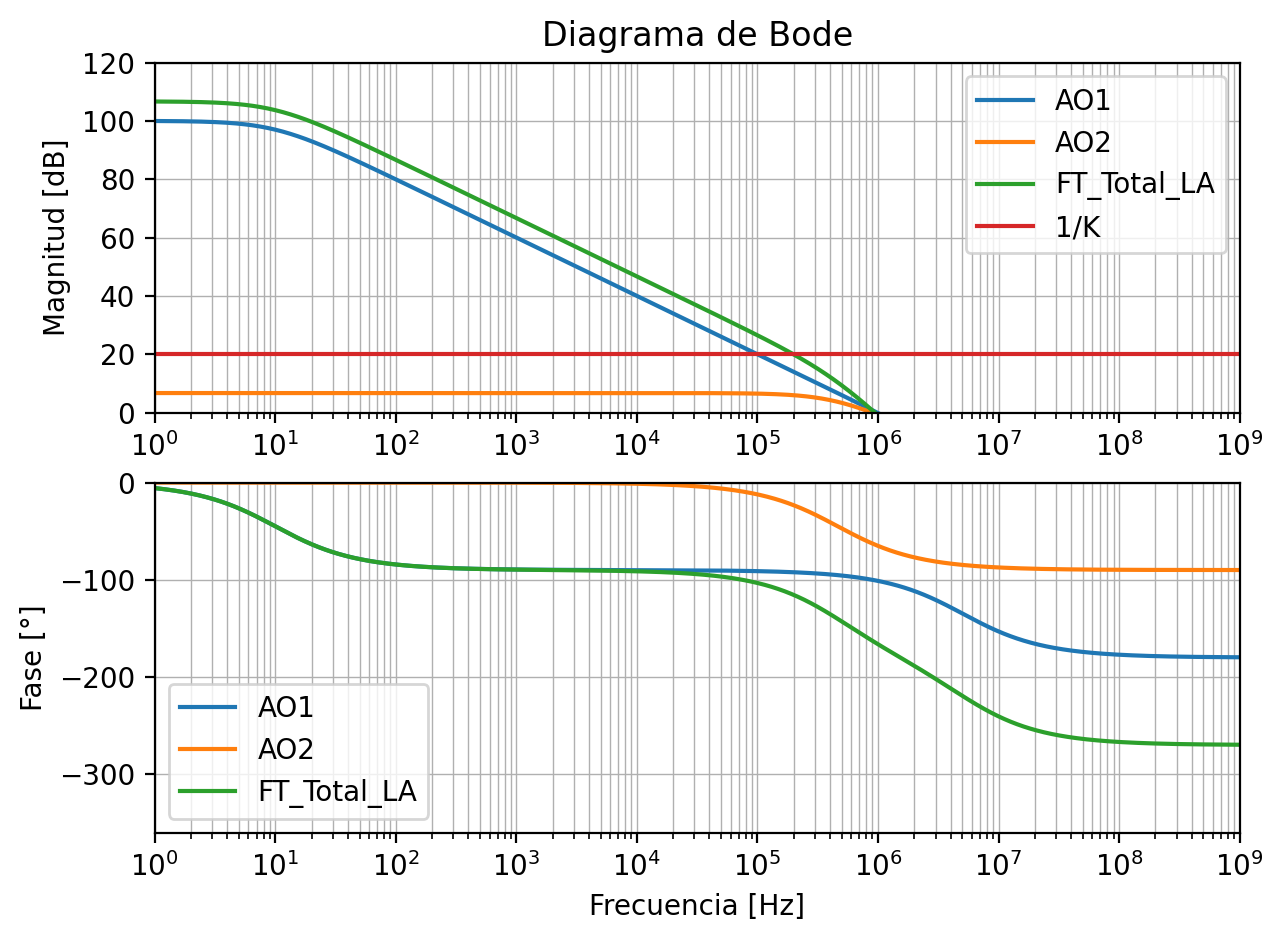

In [3]:
# ====================================
#   DIAGRAMA DE BODE DE CADA BLOQUE
# ====================================
rango_f = np.logspace(0,9,1000)

# ===========
#   MÓDULO
# ===========
plt.figure(figsize = (7, 5), dpi=200)

plt.subplot(2, 1, 1)
w, mag, phase = G1.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='AO1')
plt.title("Diagrama de Bode")
plt.ylabel("Magnitud [dB]")
plt.xlim(1e0, 1e9)                                           
plt.ylim(0, 120)
plt.grid(which='both', linewidth=0.5)

w, mag, phase = G2.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='AO2')

w, mag, phase = Gt.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='FT_Total_LA')

w, mag, phase = Gk.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, mag, label='1/K')

plt.legend()

# =========
#   FASE
# =========
plt.subplot(2, 1, 2)
w, mag, phase = G1.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, phase, label='AO1')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Fase [°]")
plt.xlim(1e0, 1e9)                                           
plt.ylim(-360, 0)
plt.grid(which='both', linewidth=0.5)

w, mag, phase = G2.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, phase, label='AO2')

w, mag, phase = Gt.bode(rango_f * 2 * np.pi)
plt.semilogx(rango_f, phase, label='FT_Total_LA')

plt.legend()


In [4]:
# ===================================
#   RESPUESTA AL ESCALÓN UNITARIO
# ===================================
# De acuerdo a lo obtenido en MATLAB:
RiseTime      = 1.0539e-06
TransientTime = 3.0258e-06
SettlingTime  = 3.0258e-06
SettlingMin   = 9.1140
SettlingMax   = 10.4883
Overshoot     = 4.8880
Undershoot    = 0
Peak          = 10.4883
PeakTime      = 2.1931e-06

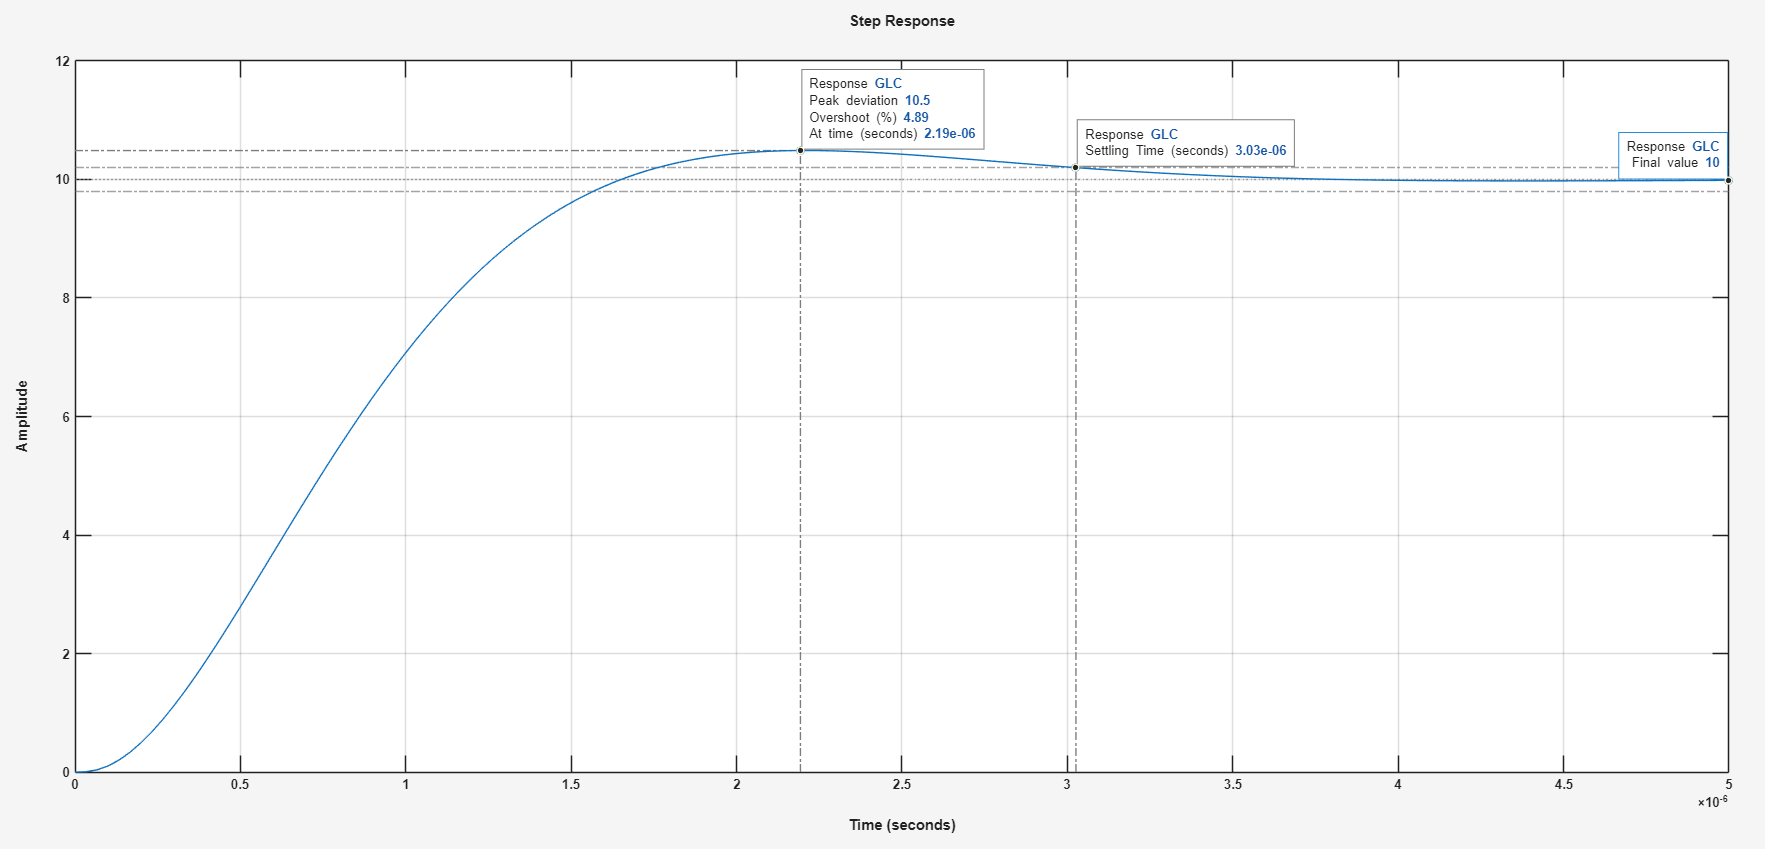

In [5]:
# ===================================
#   ESTIMACIÓN DEL MARGEN DE FASE
# ===================================
# Calculamos Zeta (Coeficiente de Amortiguamiento):
Zeta = - np.log(Overshoot / 100) / np.sqrt(((np.pi)**2 + (np.log(Overshoot / 100))**2))
# Calculamos Mp:
Mp_step = np.degrees(np.arctan(2 * Zeta / (np.sqrt(np.sqrt(1 + 4 * Zeta**4) - 2 * Zeta**2))))

print("========== Resultados ==========")
print(f"Coeficiente de Amortiguamiento:   Zeta = {Zeta:.2f}")
print(f"Margen de Fase Estimado:            Mp = {Mp_step:.2f}°")

========== Resultados ==========
Coeficiente de Amortiguamiento:   Zeta = 0.69
Margen de Fase Estimado:            Mp = 64.77°
